In [36]:
import pandas as pd
from sklearn.linear_model import LinearRegression

In [37]:
df_raw = pd.read_csv("./data/TG_STAID002759.txt", sep=",", header=14)
df = df_raw.drop(" SOUID", axis = 1)

print(df.head())

       DATE     TG   Q_TG
0  18760101     22      0
1  18760102     25      0
2  18760103      3      0
3  18760104    -58      0
4  18760105    -98      0


In [38]:
df["date"] = pd.to_datetime(df["    DATE"], format = "%Y%m%d")
df = df.drop("    DATE", axis = 1)
df.columns = ["temperature", "quality", "date"]
df.set_index("date", inplace = True, drop = True)
df["temperature"] = df["temperature"] / 10
df["timestep"] = range(len(df))
df = df.drop(df[df.quality == 9].index)

print(df.describe())

        temperature  quality      timestep
count  53527.000000  53527.0  53527.000000
mean       9.409089      0.0  26865.773273
std        7.878684      0.0  15536.326467
min      -22.600000      0.0      0.000000
25%        3.400000      0.0  13381.500000
50%        9.400000      0.0  26958.000000
75%       15.800000      0.0  40339.500000
max       30.500000      0.0  53721.000000


In [39]:
y = df["temperature"]
X = df[["timestep"]]

m = LinearRegression()
m.fit(X, y)
print(m.score(X, y))

0.004555112574137543


<Axes: xlabel='date'>

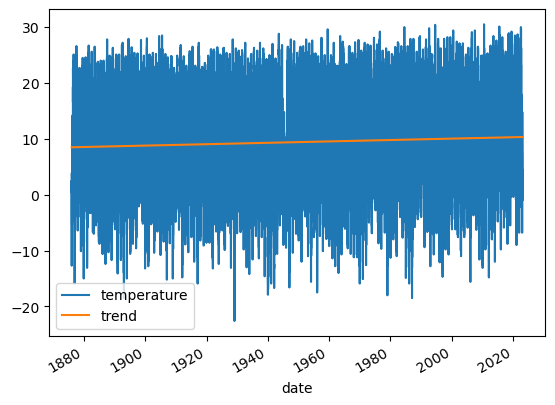

In [40]:
df["trend"] = m.predict(X)
df[["temperature", "trend"]].plot()

<Axes: xlabel='date'>

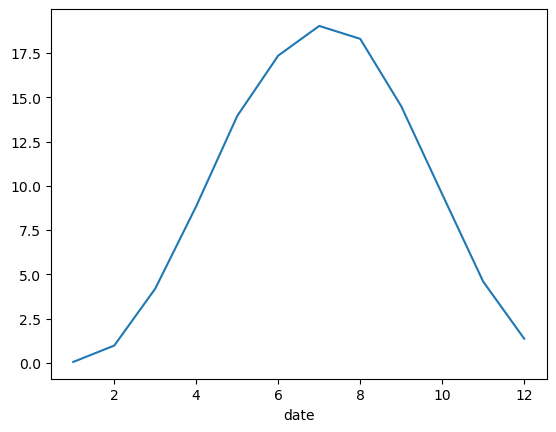

In [41]:
df.groupby(df.index.month)["temperature"].mean().plot()

In [42]:
month_dummies = pd.get_dummies(df.index.month, drop_first = True, prefix = "month").set_index(df.index)
df = df.join(month_dummies)

y = df["temperature"]
X_month_seasons = df.drop(["quality", "trend", "temperature"], axis = 1)

m = LinearRegression()
m.fit(X_month_seasons, y)
print(m.score(X_month_seasons, y))

0.7512299847932467


In [43]:
df["trend_seasonal"] = m.predict(X_month_seasons)
df["remainder"] = df["temperature"] - df["trend_seasonal"]

In [44]:
statsmodels.tsa.stattools.adfuller(df["remainder"])

(-23.826173916231916,
 0.0,
 58,
 53468,
 {'1%': -3.4304723089319324,
  '5%': -2.8615940581132935,
  '10%': -2.5667987733323874},
 241115.97124148876)

In [45]:
df["remainder"].to_csv("./output/weather_remainder.csv")
df.to_csv("./output/weather_clean.csv")